# Deep Learning for Predictive Maintenance

Deep learning has proven to show superior performance in certain domains such as object recognition and image classification. It has also gained popularity in domains such as finance where time-series data plays an important role. Predictive Maintenance is also a domain where data is collected over time to monitor the state of an asset with the goal of finding patterns to predict failures which can also benefit from certain deep learning algorithms. Among the deep learning methods, Long Short Term Memory (LSTM) networks are especially appealing to the predictive maintenance domain due to the fact that they are very good at learning from sequences. This fact lends itself to their applications using time series data by making it possible to look back for longer periods of time to detect failure patterns. In this notebook, we build an LSTM network for the data set and scenerio described at [Predictive Maintenance Template](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3) to predict remaining useful life of aircraft engines. In summary, the template uses simulated aircraft sensor values to predict when an aircraft engine will fail in the future so that maintenance can be planned in advance.

This notebook serves as a tutorial for beginners looking to apply deep learning in predictive maintenance domain and uses a simple scenario where only one data source (sensor values) is used to make predictions. In more advanced predictive maintenance scenarios such as in Predictive Maintenance Modelling Guide, there are many other data sources (i.e. historical maintenance records, error logs, machine and operator features etc.) which may require different types of treatments to be used in the deep learning networks. Since predictive maintenance is not a typical domain for deep learning, its application is an open area of research.

This notebook uses keras deep learning library with Microsoft Cognitive Toolkit CNTK as backend.

![](process.png)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, GRU
from tensorflow.python.client import device_lib

In [58]:
tf.__version__

'2.2.0'

In [59]:
device_lib.list_local_devices()

2021-10-20 16:50:37.941710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-10-20 16:50:37.941837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-20 16:50:37.941867: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-20 16:50:37.941892: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-10-20 16:50:37.941916: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-10-20 16:50:37.941940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
20

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7731476428800686673,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10701876293354804186
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11874201792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16592125989708210343
 physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:65:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3362090878467639796
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score

%matplotlib inline

## 1. Data Ingestion

In the following section, we ingest the training, test and ground truth datasets from azure storage. The training data consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. The testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs. Finally, the ground truth data provides the number of remaining working cycles for the engines in the testing data. You can find more details about the type of data used for this notebook at [Predictive Maintenance Template.](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3)

In [3]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2021-10-20 13:50:01--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.213.49, 13.107.246.49, 2620:1ec:46::49, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.213.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.2’

PM_train.txt.2      100%[===================>]   3.35M  11.3MB/s    in 0.3s    

2021-10-20 13:50:01 (11.3 MB/s) - ‘PM_train.txt.2’ saved [3515356/3515356]

--2021-10-20 13:50:01--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.213.49, 13.107.246.49, 2620:1ec:46::49, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.213.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.2’

PM_test

In [5]:
# read training data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [7]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [8]:
train_df = train_df.sort_values(['id', 'cycle'])
train_df.head(20)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


## 2. Data Preprocessing

First step is to generate labels for the training data which are Remaining Useful Life (RUL), label1 and label2 as was done in the [Predictive Maintenance Template](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3). Here, we will only make use of "label1" for binary clasification, while trying to answer the question: is a specific engine going to fail within w1 cycles?

In [9]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head(193)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,0


In [10]:
# gerate label colunms for training data
w1 = 30
w0 = 15

train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head(192)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,8.5207,0.03,396,2388,100.0,38.51,22.9588,4,1,2
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,8.5183,0.03,395,2388,100.0,38.48,23.1127,3,1,2
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,8.5223,0.03,398,2388,100.0,38.49,23.0675,2,1,2
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,8.5174,0.03,394,2388,100.0,38.45,23.1295,1,1,2


In the [Predictive Maintenance Template](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3) , cycle column is also used for training so we will also include the cycle column. Here, we normalize the columns in the training data.

In [11]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle','RUL', 'label1', 'label2'])
min_max_scaler = preprocessing.MinMaxScaler()

norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
norm_train_df

,cycle_norm,s1,s10,s11,s12,s13,s14,s15,s16,s17,...,s3,s4,s5,s6,s7,s8,s9,setting1,setting2,setting3
0,0.000000,0.0,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,...,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.459770,0.166667,0.0
1,0.002770,0.0,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,...,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.609195,0.250000,0.0
2,0.005540,0.0,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,...,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.252874,0.750000,0.0
3,0.008310,0.0,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,...,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.540230,0.500000,0.0
4,0.011080,0.0,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,...,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.390805,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.540166,0.0,0.0,0.726190,0.170576,0.558824,0.194344,0.656791,0.0,0.750000,...,0.587312,0.782917,0.0,1.0,0.254428,0.439394,0.196491,0.477011,0.250000,0.0
20627,0.542936,0.0,0.0,0.708333,0.211087,0.500000,0.188668,0.727203,0.0,0.583333,...,0.729453,0.866475,0.0,1.0,0.162641,0.500000,0.194651,0.408046,0.083333,0.0
20628,0.545706,0.0,0.0,0.738095,0.281450,0.529412,0.212148,0.922278,0.0,0.833333,...,0.684979,0.775321,0.0,1.0,0.175523,0.515152,0.198196,0.522989,0.500000,0.0
20629,0.548476,0.0,0.0,0.916667,0.208955,0.514706,0.203065,0.823394,0.0,0.583333,...,0.746021,0.747468,0.0,1.0,0.133655,0.530303,0.233285,0.436782,0.750000,0.0


In [12]:
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
join_df.head()

,RUL,cycle,id,label1,label2,cycle_norm,s1,s10,s11,s12,...,s3,s4,s5,s6,s7,s8,s9,setting1,setting2,setting3
0,191,1,1,0,0,0.00000,0.0,0.0,0.369048,0.633262,...,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.459770,0.166667,0.0
1,190,2,1,0,0,0.00277,0.0,0.0,0.380952,0.765458,...,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.609195,0.250000,0.0
2,189,3,1,0,0,0.00554,0.0,0.0,0.250000,0.795309,...,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.252874,0.750000,0.0
3,188,4,1,0,0,0.00831,0.0,0.0,0.166667,0.889126,...,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.540230,0.500000,0.0
4,187,5,1,0,0,0.01108,0.0,0.0,0.255952,0.746269,...,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.390805,0.333333,0.0


In [13]:
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [14]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Next, we use the ground truth dataset to generate labels for the test data.

In [15]:
# generate columns max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
truth_df.head()

,id,max
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [16]:
#generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [17]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


In the rest of the notebook, we train an LSTM network that we will compare to the results in Predictive [Maintenance Template Step 2B of 3](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2B-of-3-train-and-evaluate-binary-classification-models-2) where a series of machine learning models are used to train and evaluate the binary classification model that uses column "label1" as the label.

## 3. Modeling

The traditional predictive maintenance machine learning models are based on feature engineering which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenario and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering.

When using LSTMs in the time-series domain, one important parameter to pick is the sequence length which is the window for LSTMs to look back. This may be viewed as similar to picking window_size = 5 cycles for calculating the rolling features in the [Predictive Maintenance Template](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3) which are rolling mean and rolling standard deviation for 21 sensor values. The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

One critical advantage of LSTMs is their ability to remember from long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. For example, computing rolling averages over a window size of 50 cycles may lead to loss of information due to smoothing and abstracting of values over such a long period, instead, using all 50 values as input may provide better results. While feature engineering over large window sizes may not make sense, LSTMs are able to use larger window sizes and use all the information in the window as input. Below, we illustrate the approach.

In [18]:
# pick a large window size of 50 cycle
sequence_length = 50

Let's first look at an example of the sensor values 50 cycles prior to the failure for engine id 3. We will be feeding LSTM network this type of data for each time step for each engine id.

In [19]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

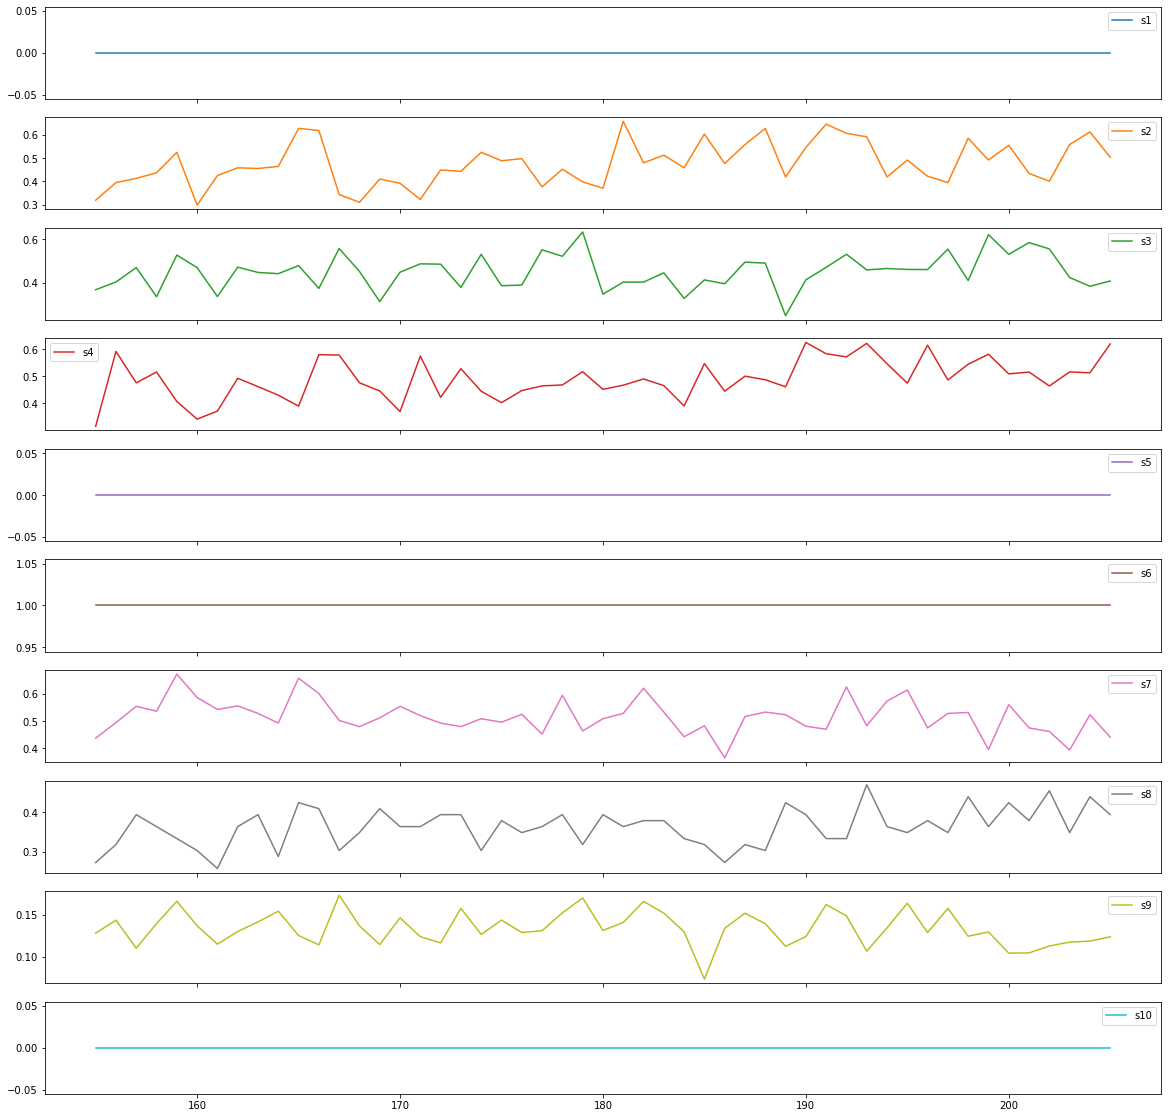

In [20]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

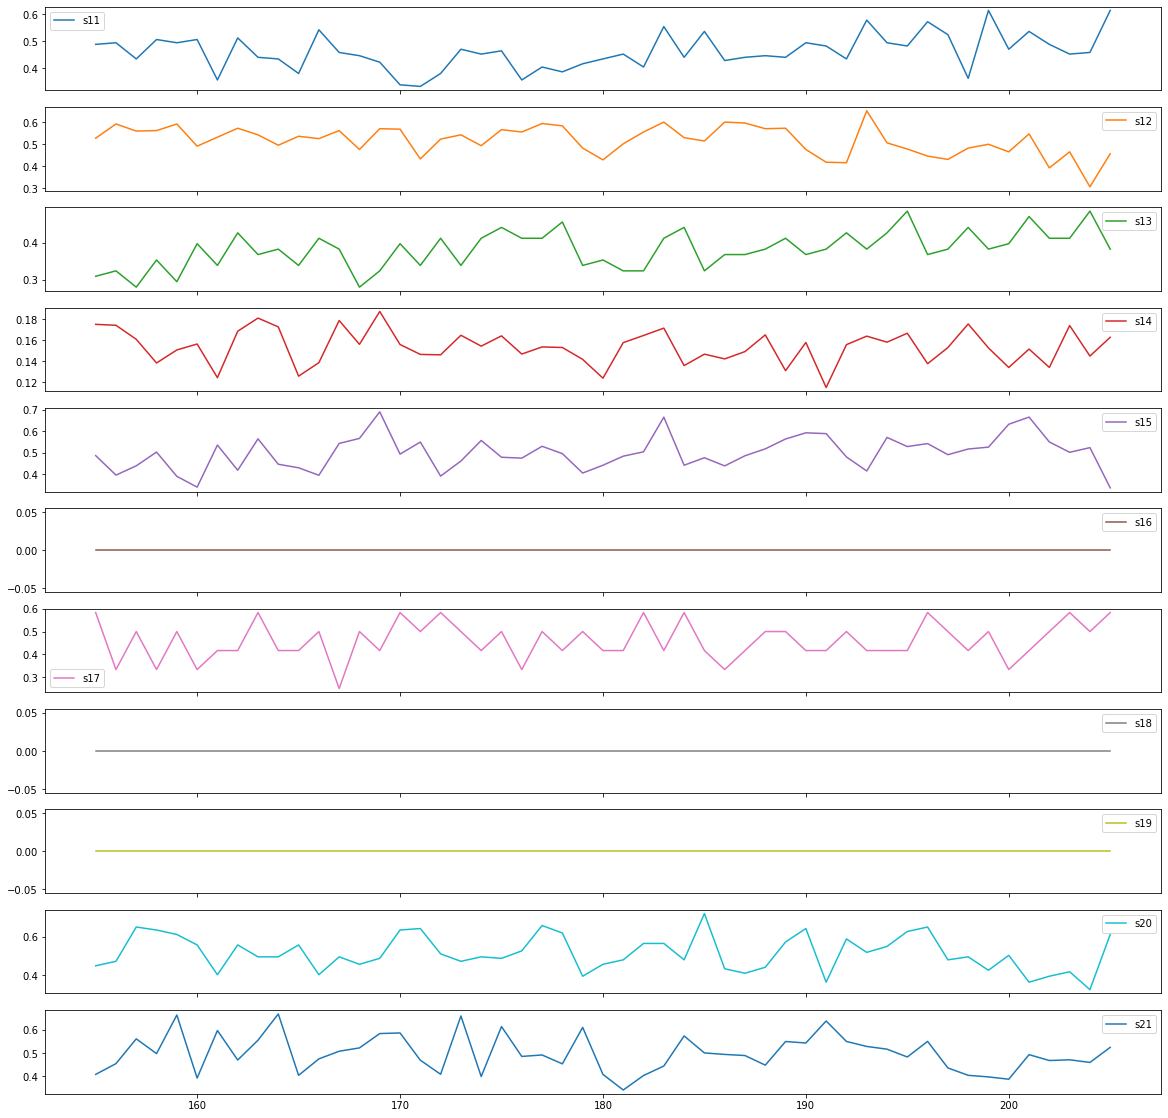

In [21]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

[Keras LSTM layers](https://keras.io/api/layers/recurrent_layers/lstm/) expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

In [22]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [23]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [24]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [25]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [26]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [27]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## 4. LSTM Network

Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.

In [60]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50, 100)           38100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
75/75 [==============================] - 1s 16ms/step - loss: 0.2677 - accuracy: 0.8858 - val_loss: 0.1776 - val_accuracy: 0.9246
Epoch 2/10
75/75 [==============================] - 1s 11ms/step - loss: 0.1345 - accuracy: 0.9430 - val_loss: 0.1218 - val_accuracy: 0.9412
Epoch 3/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0761 - accuracy: 0.9669 - val_loss: 0.0957 - val_accuracy: 0.9616
Epoch 4/10
75/75 [==============================] - 1s 11ms/step - loss: 0.0663 - accuracy: 0.9718 - val_loss: 0.0858 - val_accuracy: 0.9616
Epoch 5/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0643 - accuracy: 0.9719 - val_loss: 0.0709 - val_accuracy: 0.9668
Epoch 6/10
75/75 [==============================] - 1s 11ms/step - loss: 0.0563 - accuracy: 0.9770 - val_loss: 0.0662 - val_accuracy: 0.9668
Epoch 7/10
75/75 [==============================] - 1s 11ms/step - loss: 0.0540 - accuracy: 0.9778 - val_loss: 0.0515 - val_accuracy: 0.9770
Epoch 8/10
75

In [63]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 0s 6ms/step - loss: 0.0786 - accuracy: 0.9662
Accurracy: 0.9661570191383362


In [64]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array, verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 0s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12017,   514],
       [   15,  3085]])

In [65]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print('precision = ', precision, '\n', 'recall =', recall)

precision =  0.8571825507085301 
 recall = 0.9951612903225806


Next, we look at the performance on the test data. In the [Predictive Maintenance Template Step 1 of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2), only the last cycle data for each engine id in the test data is kept for testing purposes. In order to compare the results to the template, we pick the last sequence for each id in the test data.

In [66]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [67]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

Similarly, we pick the labels.

In [68]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [69]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [70]:
# Test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0669 - accuracy: 0.9785
Accurracy: 0.9784946441650391


In [71]:
# make predictions and compute confusion matrix
y_pred_test = model.predict_classes(seq_array_test_last, verbose=1)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is trye labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

3/3 [==============================] - 0s 3ms/step
Confusion matrix
- x-axis is trye labels.
- y-axis is predicted labels


array([[66,  2],
       [ 0, 25]])

In [72]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print(' Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score: ', f1_test)

 Precision:  0.9259259259259259 
 Recall:  1.0 
 F1-score:  0.9615384615384615


In [74]:
result_df = pd.DataFrame([[scores_test[1], precision_test, recall_test, f1_test], 
                         [0.94, 0.952381,  0.8, 0.869565]], 
                        columns=['Accruacy', 'Precision', 'Recall', 'F1-score'],
                        index=['GRU', 'Template Best Model'])
result_df

,Accruacy,Precision,Recall,F1-score
GRU,0.978495,0.925926,1.0,0.961538
Template Best Model,0.940000,0.952381,0.8,0.869565



Comparing the above test results to the predictive maintenance template, we see that the LSTM results are better than the template. It should be noted that the data set used here is very small and deep learning models are known to perform superior with large datasets so for a more fair comparison larger datasets should be used.

## Future Directions and Improvements

This tutorial covers the basics of using deep learning in predictive maintenance and many predictive maintenance problems usually involve a variety of data sources that needs to be taken into account when applying deep learning in this domain. additionallym it is important to tune the models for the right parameters such as window size. Here are some suggestions on future directions on improvements:

- Try different window sizes.
- Try different acchtectures with differenct number of layter and nodes.
- Try tuning hyperparmaters of the network.
- Try predicting RUL (regression) such as in [Predictive Maintenance Template Step 2A of 3](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2) and label2 (multi-class classification) such as in [Predictive Maintenance Template Step 2C of 3](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2).
- Try on larger data sets with more records.
- Try a different problem scenario such as in Predictive Maintance Modeling Guide where muliple other data sources are involved such as maintenance records.